## 1. Imports

In [1]:
from enum import Enum

import torch
from torch import nn, optim
import pandas as pd
import matplotlib.pyplot as plt

from torchero import SupervisedTrainer
from torchero.models.text import LinearModel
from torchero.utils.collate import BoWCollate
from torchero.utils.text import TextClassificationDataset, GLoVeVectors
from torchero.utils.data import train_test_split
from torchero.callbacks import ProgbarLogger
from torchero.hparams import OptimP
from torchero.meters import Precision, Recall, F1Score

In [2]:
USE_PRETRAINED_EMBEDDINGS = False
FREEZE_EMBEDDINGS = True

In [3]:
!head -n 1 /mnt/datasets/datasets/nlp/jigsaw-toxic-comment-classification-challenge/train.csv

"id","comment_text","toxic","severe_toxic","obscene","threat","insult","identity_hate"


In [4]:
if USE_PRETRAINED_EMBEDDINGS:
    vectors = GLoVeVectors.from_url()

In [5]:
path = r'/mnt/datasets/datasets/nlp/jigsaw-toxic-comment-classification-challenge/train.csv'
label_cols = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

## Load the dataset

In [6]:
def transform_target(target):
    return [int(x) for x in target]

if USE_PRETRAINED_EMBEDDINGS:
    train_ds = TextClassificationDataset.from_csv(path=path,
                                                  text_col='comment_text',
                                                  target_col=label_cols,
                                                  tokenizer='spacy:en',
                                                  vocab=vectors.vocab,
                                                  transform_target=transform_target,
    )
else:
    train_ds = TextClassificationDataset.from_csv(path=path,
                                                  text_col='comment_text',
                                                  target_col=label_cols,
                                                  tokenizer='spacy:en',
                                                  transform_target=transform_target,
                                                  vocab_max_size=100000)
train_ds, val_ds = train_test_split(train_ds, valid_size=0.2)
train_dl = train_ds.dataloader(collate_fn=BoWCollate(), batch_size=256, shuffle=True, num_workers=6)
val_dl = val_ds.dataloader(collate_fn=BoWCollate(), batch_size=256, shuffle=False, num_workers=6)

## Linear Model

In [8]:
len(train_ds.vocab)

100000

In [9]:
linear_model = LinearModel(len(train_ds.vocab),300,len(label_cols))

In [10]:
if USE_PRETRAINED_EMBEDDINGS:
    linear_model.embeddings.weight.data[1:,:] = vectors.matrix
    linear_model.embeddings.weight.requires_grad = not FREEZE_EMBEDDINGS

In [11]:
linear_model_trainer = SupervisedTrainer(linear_model,
                                         criterion='binary_cross_entropy_wl',
                                         optimizer='adam',
                                         acc_meters=['binary_with_logits_accuracy',
                                                     Precision(with_logits=True),
                                                     Recall(with_logits=True),
                                                     F1Score(with_logits=True)],
                                       callbacks=[ProgbarLogger(notebook=True)])
linear_model_trainer.to('cuda')
linear_model_trainer.train(train_dl, val_dl, epochs=10)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

### Training results

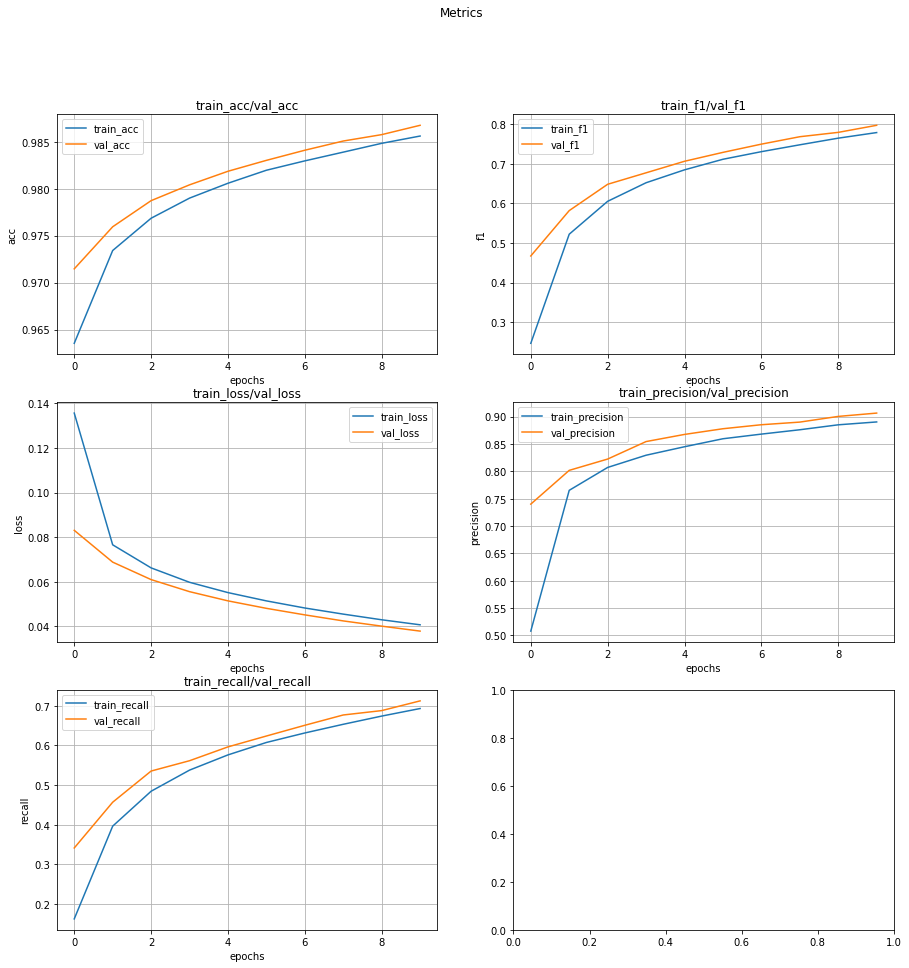

In [12]:
linear_model_trainer.history.plot()
plt.show()

## Convolutional Network

In [13]:
class Conv1DBlock(nn.Module):
    def __init__(self, c_in, c_out, kernel_size=3, padding=(0, 0), stride=1, max_pool=True):
        super(Conv1DBlock, self).__init__()
        self.padding = nn.ConstantPad1d(padding, 0)
        self.conv = nn.Conv1d(c_in, c_out, kernel_size=kernel_size, stride=stride, padding=0)
        self.batch_norm = nn.BatchNorm1d(c_out)
        self.act = nn.ReLU(inplace=True)
        self.max_pool = nn.MaxPool1d(2) if max_pool else None
    
    def forward(self, x):
        x = self.act(self.batch_norm(self.conv(self.padding(x))))
        if self.max_pool is not None:
            x = self.max_pool(x)
        return x

class Conv1DSuperBlock(nn.Module):
    def __init__(self, c_in, c_out, kernel_sizes=[3], padding=[(0, 0)], stride=1, max_pool=True):
        super(Conv1DSuperBlock, self).__init__()
        assert(len(padding) == len(kernel_sizes))
        self.convs = [Conv1DBlock(c_in, c_out, kernel_size=k, padding=p, stride=stride, max_pool=max_pool)
                      for k, p in zip(kernel_sizes, padding)]
    
    def to(self, device):
        super(Conv1DSuperBlock, self).to(device)
        for conv in self.convs:
            conv.to(device)
        
    
    def forward(self, x):
        outputs = [conv(x) for conv in self.convs]
        return torch.cat(outputs, dim=1)
    

class ConvModel(nn.Module):
    def __init__(self, outputs, embedding_dim=50):
        super(ConvModel, self).__init__()
        self.embeddings = nn.Embedding(len(train_ds.vocab), embedding_dim=embedding_dim, padding_idx=train_ds.vocab[train_ds.vocab.pad])
        self.convs = nn.Sequential(Conv1DSuperBlock(embedding_dim, 32, [1,2,3], [(0, 0), (1, 0), (2, 0)]),
                                   Conv1DSuperBlock(32*3, 16, [1,2,3], [(0, 0), (1, 0), (2,0)]),
                                   Conv1DBlock(16*3, 20, 3, padding=(1,1), stride=1, max_pool=False),
                                   nn.AdaptiveMaxPool1d(1),
                                   nn.Flatten(),
                                   nn.Linear(20, 10),
                                   nn.ReLU(),
                                   nn.Dropout(0.5),
                                   nn.Linear(10, outputs))
        
    def to(self, device):
        super(ConvModel, self).to(device)
        self.embeddings.to(device)
        self.convs[0].to(device)
        self.convs[1].to(device)
        self.convs[2].to(device)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = x.transpose(-1, 1)
        x = self.convs(x)
        return x

In [14]:
conv_model = ConvModel(len(label_cols), 100)

In [15]:
conv_trainer = SupervisedTrainer(conv_model,
                                 criterion='binary_cross_entropy_wl',
                                 optimizer='adam',
                                 acc_meters=['binary_with_logits_accuracy',
                                              Precision(with_logits=True),
                                              Recall(with_logits=True),
                                              F1Score(with_logits=True)],
                                 callbacks=[ProgbarLogger(notebook=True)])
conv_trainer.to('cuda')

train_dl = train_ds.dataloader(batch_size=256, shuffle=True, num_workers=6)
val_dl = val_ds.dataloader(batch_size=256, shuffle=False, num_workers=6)
conv_trainer.train(train_dl, val_dl, epochs=10)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

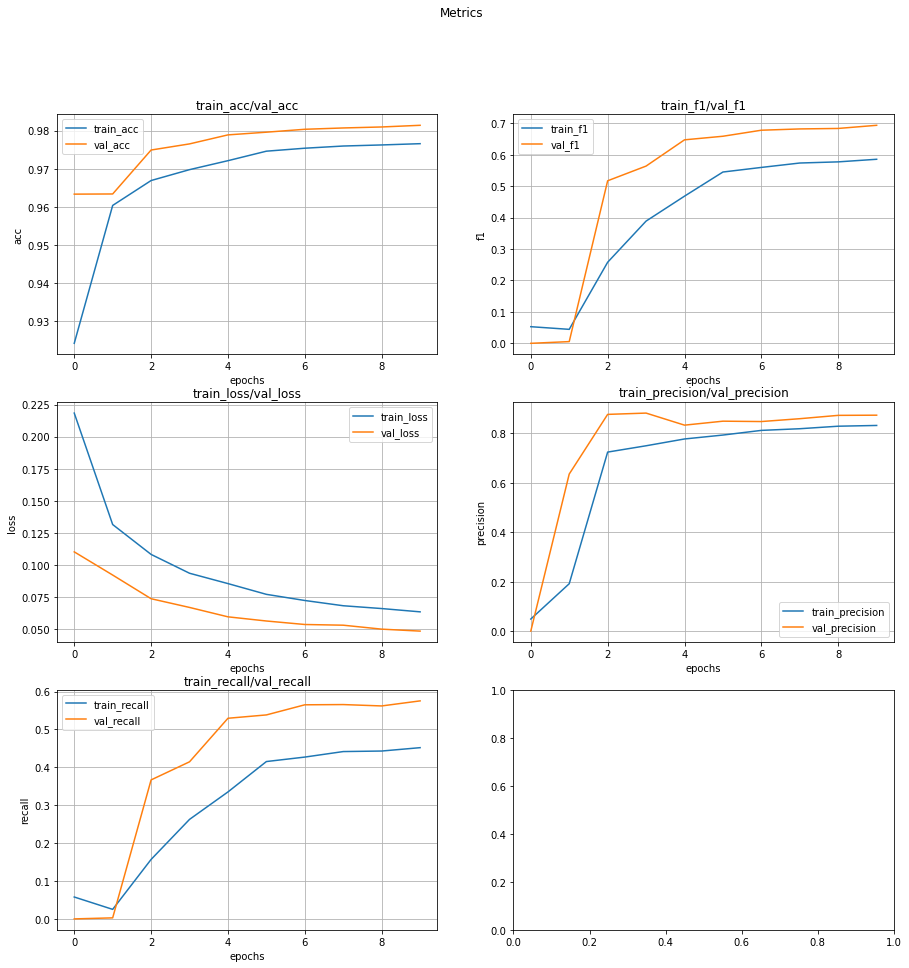

In [16]:
conv_trainer.history.plot()
plt.show()

In [20]:
pd.DataFrame.from_dict({
    'linear': linear_model_trainer.metrics,
    'convnet': conv_trainer.metrics})

,linear,convnet
train_acc,0.985616,0.976575
train_precision,0.890329,0.832476
train_recall,0.692974,0.451935
train_f1,0.779351,0.585832
train_loss,0.040724,0.063331
val_acc,0.986759,0.981395
val_precision,0.906516,0.874021
val_recall,0.712263,0.575417
val_f1,0.797734,0.693961
val_loss,0.037895,0.048302
